# Housing Price Predictor

## Configuration

In [161]:
# Librairies

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from xgboost import XGBRegressor

## Global

In [162]:
# Functions

def analyse(data):
	nas = data.isna().sum()
	nuniques = data.nunique()
	types = data.dtypes
	
	return pd.DataFrame({
		"NA": nas,
		"Uniques": nuniques,
		"types": types
	})

def clean(data):
	# Data Selection
	data = data[data["Nature mutation"] == "Vente"]
	data = data[data["Type local"].isin(["Appartement", "Maison"])]

	# Data Cleaning
	data = data.dropna()

	return data

def merge(data_chunks, clean_func, columns):
	data = pd.DataFrame(columns=columns)

	for data_chunk in data_chunks:
		data_chunk = clean_func(data_chunk)
		data = pd.concat([data_chunk, data])
		if data.shape[0] >= 100_000:
			break
	
	data = data.drop(["Nature mutation"], axis=1)
	data = data.reset_index(drop=True)

	return data

## Data

### Data Retrieval

In [163]:
# Data Retrieval

columns = [
	"Code departement", "Code postal", "Code commune", "Nature mutation", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Date mutation", "Valeur fonciere"
]
data_chunks = pd.read_csv("./data/ValeursFoncieres-2024.txt", sep="|", usecols=columns, chunksize=10_000)

# Geo Features Data

geo_features_columns = [
	"code_commune", "latitude", "longitude"
]

data_geo = pd.read_csv("./data/20230823-communes-departement-region.csv", sep=",", usecols=geo_features_columns)

In [164]:
# Data Preparation

data = merge(data_chunks, clean, columns)
y = data["Valeur fonciere"]
x = data.copy().drop(["Valeur fonciere"], axis=1)

data_geo = data_geo.dropna()

/tmp/ipykernel_474367/3695465181.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_chunk, data])


In [165]:
# Analysis

analyse(data)

,NA,Uniques,types
Date mutation,0,314,object
Valeur fonciere,0,14620,object
Code postal,0,1037,float64
Code departement,0,19,object
Code commune,0,800,object
Type local,0,2,object
Surface reelle bati,0,455,float64
Nombre pieces principales,0,25,float64
Surface terrain,0,4862,float64


In [166]:
# Anaysis

analyse(data_geo)

,NA,Uniques,types
latitude,0,35921,float64
longitude,0,35921,float64
code_commune,0,908,float64


In [167]:
# Data Join

data = pd.merge(data, data_geo, left_on="Code commune", right_on="code_commune")

In [168]:
# Data Cleaning

data = data.drop(["Code commune", "Code departement", "code_commune"], axis=1)

In [169]:
# Analysis

analyse(data)

,NA,Uniques,types
Date mutation,0,314,object
Valeur fonciere,0,14620,object
Code postal,0,1037,float64
Type local,0,2,object
Surface reelle bati,0,455,float64
Nombre pieces principales,0,25,float64
Surface terrain,0,4862,float64
latitude,0,35488,float64
longitude,0,35488,float64


### Data Preparation

#### Transformers

In [170]:
# Type Transformer

class TypeTransformer(BaseEstimator, TransformerMixin):
	def __init__(self, str_features = None, num_features = None):
		if not str_features:
			self.str_features = ["Code postal", "Type local"]
		else:
			self.str_features = str_features

		if not num_features:
			self.num_features = ["Surface reelle bati", "Nombre pieces principales", "Surface terrain"]
		else:
			self.num_features = num_features
	
	def fit(self, X, y = None):
		return self

	def transform(self, X, y = None):
		X_ = X.copy()

		X_["Date mutation"] = pd.to_datetime(X_["Date mutation"], dayfirst=True)

		for column in self.str_features:
			X_[column] = X_[column].values.astype(str)

		for column in self.num_features:
			X_[column] = X_[column].values.astype(float)
		
		return X_

In [171]:
# One Hot Encoding Transformer

class OneHotEncodingTransformer(BaseEstimator, TransformerMixin):
	def __init__(self, columns = None):
		if not columns:
			self.columns = ["Code postal", "Type local"]
		else:
			self.columns = columns
	
	def fit(self, X, y = None):
		return self
	
	def transform(self, X, y = None):
		X_ = X.copy()

		X_ = pd.get_dummies(X_, columns=self.columns)
		X_ = X_.drop(self.columns, axis=1)

		return X_

In [172]:
# Date Transformer

class DateTransformer(BaseEstimator, TransformerMixin):
	def __init__(self, date_column="Date mutation"):
		self.date_column = date_column
		self.scaler = StandardScaler()
	
	def fit(self, X, y=None):
		X_ = X.copy()

		# Tendance temporelle
		self.min_date = X_[self.date_column].min()
		X_["Jours_depuis"] = (X_[self.date_column] - self.min_date).dt.days

		# Scaler
		self.scaler.fit(X_[["Jours_depuis"]].values.astype(float))
		
		return self
	
	def transform(self, X, y = None):
		X_ = X.copy()

		# Tendance temporelle
		X_["Jours_depuis"] = (X_[self.date_column] - self.min_date).dt.days
		X_["Jours_depuis"] = self.scaler.transform(X_[["Jours_depuis"]].values.astype(float))

		# Suppression des colonnes redondantes
		X_ = X_.drop(columns=[self.date_column], axis=1)

		return X_


#### Transformation

In [173]:
# Data Transformation Pipeline

categorical_features = ["Code postal", "Type local"]
numerical_features = ["Surface reelle bati", "Nombre pieces principales", "Surface terrain"]

column_transformer = ColumnTransformer(
	transformers=[
		("num", StandardScaler(), numerical_features + ["Jours_depuis"]),
		("cat", OneHotEncoder(), categorical_features)
	],
	remainder="passthrough"
)

prep_pipeline = Pipeline([
	("type", TypeTransformer()),
	("date", DateTransformer()),
	("cols", column_transformer)
])

prep_pipeline

,steps,"[('type', ...), ('date', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,str_features,"['Code postal', 'Type local']"
,num_features,"['Surface reelle bati', 'Nombre pieces principales', ...]"
,date_column,'Date mutation'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None


In [174]:
# Data Transformation

x = prep_pipeline.fit_transform(x)
y = y.str.replace(",", ".").astype(float)

In [175]:
# Data Splitting

x_train, x_test, y_train, y_test = train_test_split(x, y)

## Model Training

In [176]:
# Functions

def train_test(model, x_train, y_train, x_test, y_test, transform=False):
	yeo = PowerTransformer("yeo-johnson")
	y_train_ = yeo.fit_transform(y_train.values.reshape(-1, 1)) if transform else y_train

	# Training
	m = model()
	m.fit(x_train, y_train_)

	# Validation
	train_pred_yeo = m.predict(x_train)
	train_pred = yeo.inverse_transform(train_pred_yeo) if transform else train_pred_yeo

	train_results = (
		round(np.sqrt(mean_squared_error(y_train, train_pred)), 2),
		round(r2_score(y_train, train_pred), 2),
		round(mean_absolute_error(y_train, train_pred), 2)
	)

	# Test
	test_pred_yeo = m.predict(x_test)
	test_pred = yeo.inverse_transform(test_pred_yeo) if transform else test_pred_yeo

	test_results = (
		round(np.sqrt(mean_squared_error(y_test, test_pred)), 2),
		round(r2_score(y_test, test_pred), 2),
		round(mean_absolute_error(y_test, test_pred), 2)
	)

	return m, train_results, test_results, train_pred, test_pred, yeo

def plot_results(y_train, train_pred, y_test, test_pred):
	fig, axs = plt.subplots(1, 2)
	axs[0].scatter(y_train, train_pred, s=10, color="black")
	axs[0].plot(
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		color="red"
	)
	axs[0].set_title("Train")

	axs[1].scatter(y_test, test_pred, s=10, color="black")
	axs[1].plot(
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		color="red"
	)
	axs[1].set_title("Test")

	fig.set_figwidth(15)
	fig.set_figheight(5)

### Linear Regression

In [177]:
# Training & Test

m, train_results, test_results, train_pred, test_pred, yeo = train_test(LinearRegression, x_train, y_train, x_test, y_test)

In [178]:
# Model

m

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [179]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

Train - RAE : 1164415.62 - RMSE : 3959942.45 - R2 : 0.58
Test - RAE : 1172318.19 - RMSE : 3954284.72 - R2 : 0.59


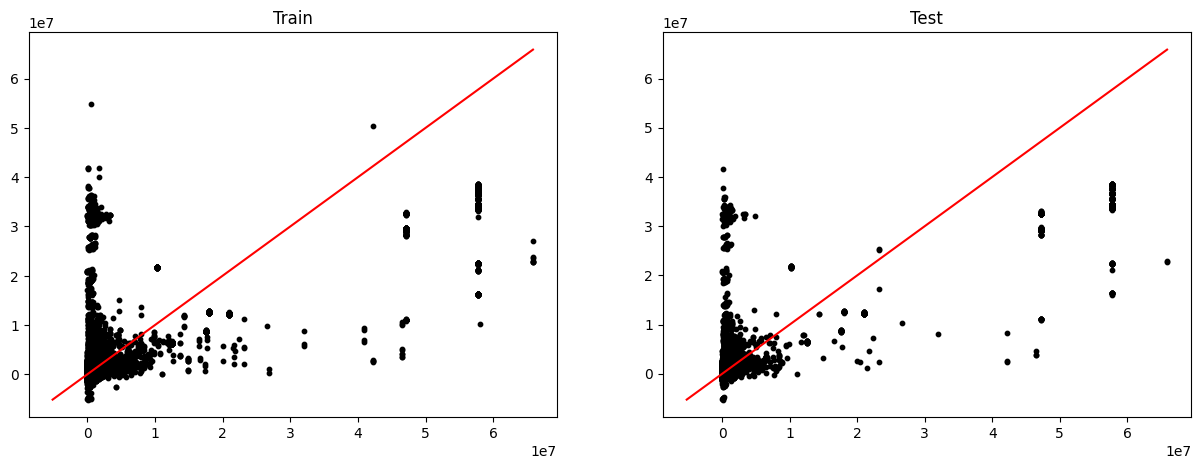

In [180]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)

### XGBoost

In [181]:
# Training & Test

m, train_results, test_results, train_pred, test_pred, yeo = train_test(XGBRegressor, x_train, y_train, x_test, y_test)

In [182]:
# Model

m

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [183]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

Train - RAE : 153432.73 - RMSE : 391580.94 - R2 : 1.0
Test - RAE : 188374.33 - RMSE : 814654.23 - R2 : 0.98


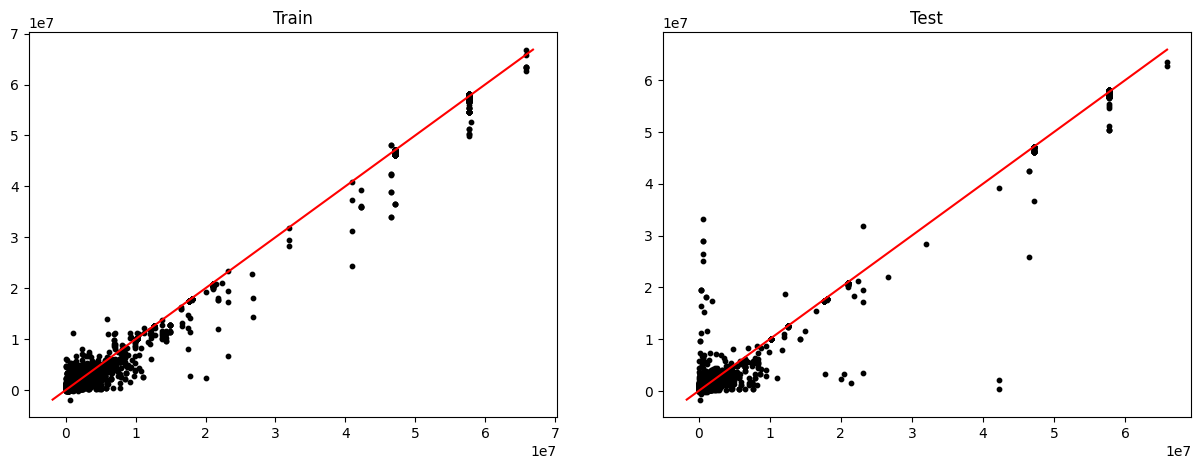

In [184]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)